In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

In [2]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.90):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [3]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
  for filename in os.scandir(path):
#     img = Image.open(os.path.join(path, filename.name))
#     img_resized= img.resize(new_size)
#     img_resized.save(os.path.join(new_path, filename.name))
    copyfile(os.path.join(path, filename.name), os.path.join(new_path, filename.name))

In [4]:
# Membuat direktori untuk menempatka data yang akan digunakan

resized_dir = './train'
source_dir = './data'

if os.path.exists(resized_dir):
  shutil.rmtree(resized_dir)

def create_train_valid_dirs(resized_path):
  os.mkdir(resized_path)
  os.mkdir(os.path.join(resized_path, 'train'))
  os.mkdir(os.path.join(resized_path, 'valid'))

  for foldername in os.listdir(os.path.join(source_dir, 'train')):
    for i in os.listdir(resized_path):
         os.mkdir(os.path.join(resized_path, i, foldername))

try:
  create_train_valid_dirs(resized_path=resized_dir)
except FileExistsError:
  print("File Sudah Ada")

In [5]:
# Train Source
train_miner_source = os.path.join(source_dir, 'train/miner/')
train_healthy_source = os.path.join(source_dir, 'train/nodisease/')
train_phoma_source = os.path.join(source_dir, 'train/phoma/')
train_rust_source = os.path.join(source_dir, 'train/rust/')

# valid Source
valid_miner_source = os.path.join(source_dir, 'valid/miner/')
valid_healthy_source = os.path.join(source_dir, 'valid/nodisease/')
valid_phoma_source = os.path.join(source_dir, 'valid/phoma/')
valid_rust_source = os.path.join(source_dir, 'valid/rust/')

# Train Resized
train_miner_resized = os.path.join(resized_dir, 'train/miner/')
train_healthy_resized = os.path.join(resized_dir, 'train/nodisease/')
train_phoma_resized = os.path.join(resized_dir, 'train/phoma/')
train_rust_resized = os.path.join(resized_dir, 'train/rust/')

# valid Resized
valid_miner_resized = os.path.join(resized_dir, 'valid/miner/')
valid_healthy_resized = os.path.join(resized_dir, 'valid/nodisease/')
valid_phoma_resized = os.path.join(resized_dir, 'valid/phoma/')
valid_rust_resized = os.path.join(resized_dir, 'valid/rust/')

In [6]:
# Melihat contoh ukuran dataset
sample_image  = load_img('./data/train/bercak-daun/20241027_124426_jpg.rf.6aa3233e0cdcfcc848cf051596313831.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

sample_image  = load_img('./data/valid/bercak-daun/WhatsApp-Image-2024-11-01-at-16-33-45_ad59510e_jpg.rf.53f1f39a075b8117bbb254299a3b069e.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (640, 640, 3)
Each image has shape: (640, 640, 3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path dataset
train_dir = './data/train'
valid_dir = './data/valid'

# Data augmentation untuk data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator untuk validasi
valid_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator untuk memuat data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resolusi gambar untuk ResNet
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 686 images belonging to 4 classes.
Found 141 images belonging to 4 classes.


In [8]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Tentukan path folder train dan validation
train_dir = './data/train'
valid_dir = './data/valid'
test_dir = './data/test'

# Tentukan dimensi gambar yang diharapkan
input_shape = (224, 224)

# Load dataset train dan valid menjadi array numpy
train_images = []
train_labels = []
val_images = []
val_labels = []
classes = ['bercak-daun', 'hawar-daun', 'karat-daun', 'pengorok-daun']

# Fungsi untuk memuat dan mengubah ukuran gambar
def load_and_resize_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    return img_to_array(img)

# Memuat dataset train
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img_array = load_and_resize_image(image_path, input_shape)
        train_images.append(img_array)
        train_labels.append(class_index)

# Memuat dataset validation
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(valid_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img_array = load_and_resize_image(image_path, input_shape)
        val_images.append(img_array)
        val_labels.append(class_index)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Pastikan dimensi gambar sudah benar
print("Train Images shape:", train_images.shape)
print("Validation Images shape:", val_images.shape)


Train Images shape: (686, 224, 224, 3)
Validation Images shape: (141, 224, 224, 3)


In [9]:
# Load dataset test
test_images = []
test_labels = []  # Tambahkan jika ada label untuk dataset test

for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img_array = load_and_resize_image(image_path, input_shape)
        test_images.append(img_array)
        test_labels.append(class_index)  # Opsional jika ada label

test_images = np.array(test_images)
print("Test Images shape:", test_images.shape)


Test Images shape: (92, 224, 224, 3)


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Tentukan input_shape sesuai dengan ResNet50 (224, 224, 3)
input_shape = (224, 224, 3)

# Muat model ResNet50 dengan pre-trained weights dan exclude top layer (untuk fine-tuning)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Tambahkan layer tambahan setelah base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')  # 4 kelas output
])

# Freeze base model
base_model.trainable = False

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
history = model.fit(
    train_images, 
    train_labels, 
    epochs=25, 
    verbose=1, 
    validation_data=(val_images, val_labels)
)


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.3766 - loss: 1.5117 - val_accuracy: 0.4681 - val_loss: 1.1628
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5501 - loss: 1.0228 - val_accuracy: 0.6454 - val_loss: 0.9822
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6629 - loss: 0.8117 - val_accuracy: 0.6525 - val_loss: 0.9126
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6745 - loss: 0.7258 - val_accuracy: 0.6525 - val_loss: 0.8735
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7746 - loss: 0.6386 - val_accuracy: 0.6596 - val_loss: 0.8891
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8018 - loss: 0.5831 - val_accuracy: 0.6950 - val_loss: 0.8197
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8433 - loss: 0.5083 - val_accuracy: 0.6738 - val_loss: 0.7906
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8678 - loss: 0.4743 - val_accuracy: 0.6950 - val_loss:

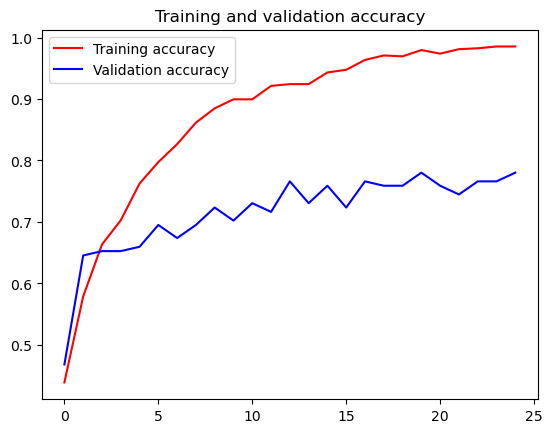

<Figure size 640x480 with 0 Axes>

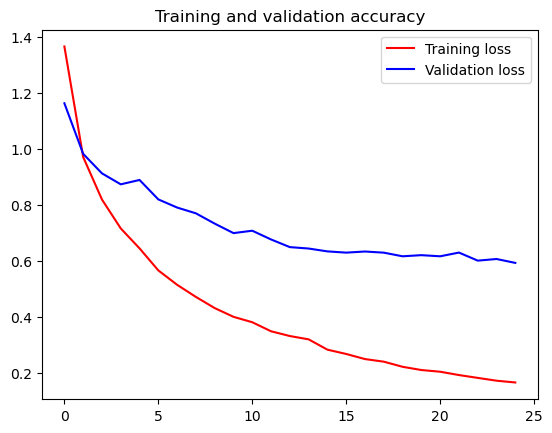

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step


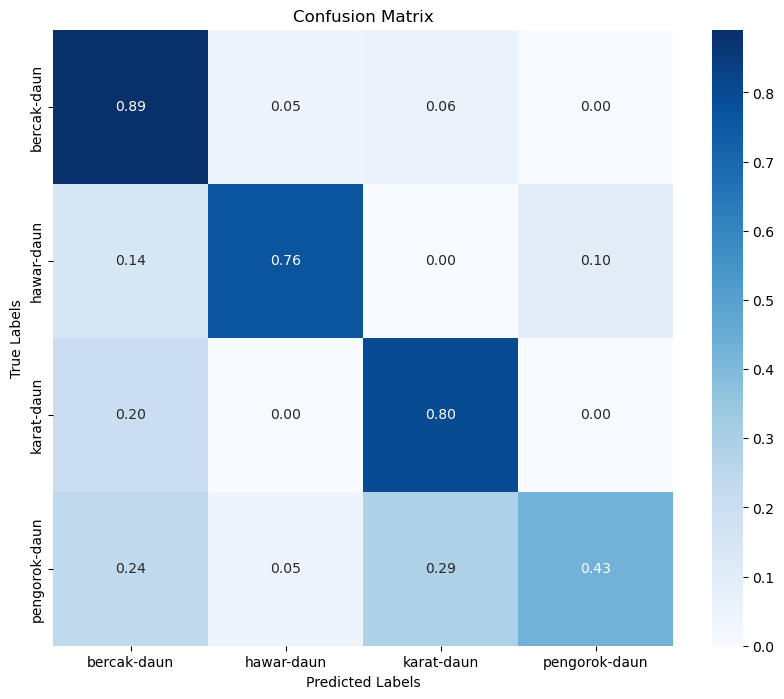

In [12]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(val_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        40
           1       0.77      1.00      0.87        17
           2       0.90      0.78      0.84        23
           3       0.80      0.67      0.73        12

    accuracy                           0.84        92
   macro avg       0.83      0.82      0.82        92
weighted avg       0.84      0.84      0.83        92



In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


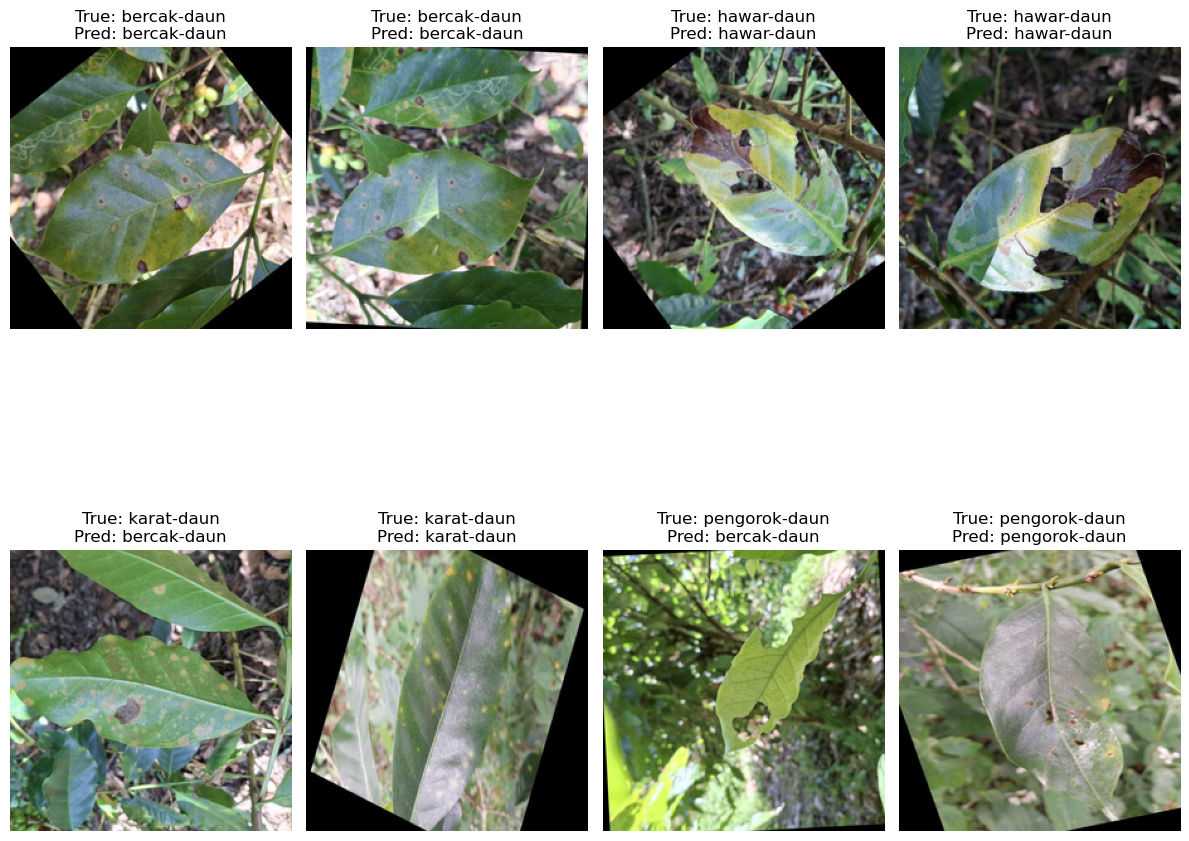

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Tentukan path folder test
test_dir = './data/test'

# Tentukan dimensi gambar yang diharapkan
input_shape = (224, 224)

# Fungsi untuk memuat dan mengubah ukuran gambar
def load_and_resize_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    return img_to_array(img)

# Memuat dataset test
test_images = []
test_labels = []  # Tambahkan jika ada label untuk dataset test

# Ambil 8 gambar sampel yang berasal dari kelas yang berbeda
sample_images = []
sample_labels = []

# Pilih 2 gambar dari setiap kelas di test_dir untuk membuat 8 gambar
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    # Ambil 2 gambar pertama dari setiap kelas
    for image_name in os.listdir(class_dir)[:2]:
        image_path = os.path.join(class_dir, image_name)
        img_array = load_and_resize_image(image_path, input_shape)
        sample_images.append(img_array)
        sample_labels.append(class_index)

# Prediksi untuk gambar sampel
sample_images = np.array(sample_images)
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Visualisasi 8 gambar dengan label dan prediksi
plt.figure(figsize=(12, 12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = sample_images[i] / 255.0  # Normalisasi gambar
    plt.imshow(img)
    true_label = classes[sample_labels[i]]
    pred_label = classes[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
